In [2]:
import requests
from bs4 import BeautifulSoup
import csv
import re
import nltk
import matplotlib.pyplot as plt
import random
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from collections import Counter, defaultdict

nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
sw = stopwords.words("spanish") # Lista de stopwords
ss = SnowballStemmer("spanish") # Stemmer

# Url del la primera página de los comentaris del hotel
url = "https://www.tripadvisor.com.mx/Hotel_Review-g292027-d674247-Reviews-Tranquility_Bay_Beach_Retreat-Trujillo_Colon_Department.html#REVIEWS"

def recolectar_comentarios(url, paginas=2):
  """Recolecta los comentarios(documentos) de tripadvisor y los guarda en una lista"""
  comentarios = []

  for i in range(paginas): 
      print(f"Consiguiendo los comentarios de la página {i+1}")
    
      r = requests.get(url) 
      soup = BeautifulSoup(r.content, "html.parser") 
      comentarios_pagina = soup.findAll("q", attrs={'class': 'IRsGHoPm'})
      comentarios_pagina = [ c.text for c in comentarios_pagina] 
      comentarios.append(comentarios_pagina)

      # Conseguir el url de la pagina siguiente
      url =  "https://www.tripadvisor.com.mx" + soup.find("a", attrs={"class": "ui_button nav next primary "})["href"]
    
  return comentarios

def procesar_comentarios(comentarios, remover_stopwords = True):
  """Procesa una lista de comentarios y retorna una lista de listas de palabras"""
  resultados = []

  for comentario in comentarios:
    comentario = comentario.lower() # Pasarlo a minuscula
    comentario = re.sub(r"[^a-z áéíóúñü]", "", comentario) # Elimina todo lo que no sea letras o espacios
    comentario = word_tokenize(comentario, "spanish") # Separa la oración en palabras
    if remover_stopwords: # Remueve las stopwords
      comentario = [palabra for palabra in comentario if palabra not in sw]
    comentario = [ss.stem(palabra) for palabra in comentario] # Hace stemming a las palabras
    resultados.append(comentario)

  return resultados

def guardar_comentarios(nombre_archivo, comentarios):
  """Guarda una lista de comentarios en un archivo .csv"""
  with open(nombre_archivo, "w") as f:
    writer = csv.writer(f)

    writer.writerow(["comentario"])
    for comentario in comentarios:
      writer.writerow(comentario)

def cargar_comentarios(nombre_archivo):
  with open(nombre_archivo, "r") as f:
    reader = csv.reader(f)
    next(reader)

    comentarios = []
    for r in reader:
      comentarios.append(r[0])

  return comentarios

def palabras_mas_probables(dist, N=10):
  palabras, probabilidad = zip(*Counter(dist).most_common(N))
  plt.figure(figsize=(15, 5))
  plt.bar(palabras, probabilidad)
  plt.show()

# Recolección y guardado de comentarios

In [4]:
comentarios = recolectar_comentarios(url, 20)
guardar_comentarios("comentarios.csv", comentarios)

Consiguiendo los comentarios de la página 1
Consiguiendo los comentarios de la página 2
Consiguiendo los comentarios de la página 3
Consiguiendo los comentarios de la página 4
Consiguiendo los comentarios de la página 5
Consiguiendo los comentarios de la página 6
Consiguiendo los comentarios de la página 7
Consiguiendo los comentarios de la página 8
Consiguiendo los comentarios de la página 9
Consiguiendo los comentarios de la página 10
Consiguiendo los comentarios de la página 11
Consiguiendo los comentarios de la página 12
Consiguiendo los comentarios de la página 13
Consiguiendo los comentarios de la página 14
Consiguiendo los comentarios de la página 15
Consiguiendo los comentarios de la página 16
Consiguiendo los comentarios de la página 17
Consiguiendo los comentarios de la página 18
Consiguiendo los comentarios de la página 19
Consiguiendo los comentarios de la página 20


# Carga y procesamiento de comentarios

In [5]:
comentarios = cargar_comentarios("comentarios.csv")
comentarios_procesados = procesar_comentarios(comentarios, remover_stopwords=False)

In [6]:
# Cuando hay más de un documento
# c(w, d) - Lista de frecuencias de palabras por comentario frec[n][w] = frecuencia de la palabra w en el comentario n
# frec = [Counter(c) for c in comentarios_procesados]

## PLSA para solo un documento y un tema

In [7]:
# Hacer un solo documento de todos los comentarios (usado para estimar el modelo de fondo)
corpus = [palabra for comentario in comentarios_procesados for palabra in comentario]

# Solo tomamos la mitad de los comentarios para evitar el problema que se dio con el modelo de fondo al utilizar todos los datos
N = len(comentarios_procesados) // 2
C = [palabra for comentario in comentarios_procesados[:N] for palabra in comentario]

In [8]:
vocab = set(C)

In [9]:
# Estimación del tema de fondo p(w | theta_B) con el corpus
frec = Counter(C) # Este solo aplica para el caso de un solo documento
Ptheta_B = Counter(corpus)
for palabra in Ptheta_B:
  Ptheta_B[palabra] /= len(corpus)

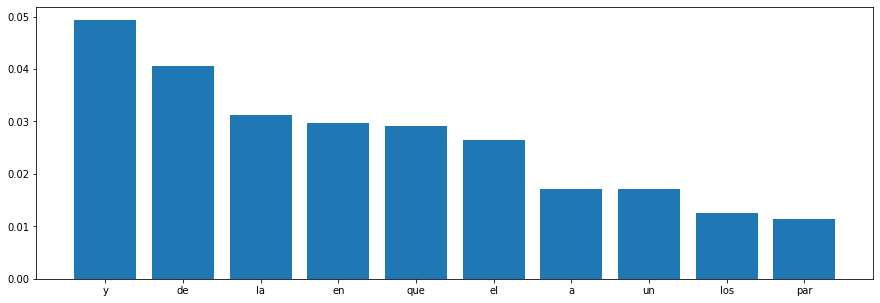

In [10]:
# Gráfica de las 10 palabras más frecuentes
palabras_mas_probables(Ptheta_B)

In [11]:
# P(theta_d)
theta_d = 0.1
# P(theta_B) se debe cumplir P(theta_d) + P(theta_B) = 1
theta_B = 1.0 - theta_d
# P(z = 0 | w)
Pz_0 = defaultdict(lambda : 0.0, {palabra:0.0 for palabra in vocab})
# P(w | theta_d)
Ptheta_d = defaultdict(lambda : 0.0, {palabra:1/len(vocab) for palabra in vocab})

In [12]:
# Paso E
for i in range(20):
  for w in vocab:
    Pz_0[w] = theta_d * Ptheta_d[w] / (theta_d * Ptheta_d[w] + theta_B * Ptheta_B[w])

  # Paso M
  denominador = 0.0
  for w in vocab:
    denominador += frec[w] * Pz_0[w]

  for w in vocab:
    Ptheta_d[w] = frec[w] * Pz_0[w] / denominador

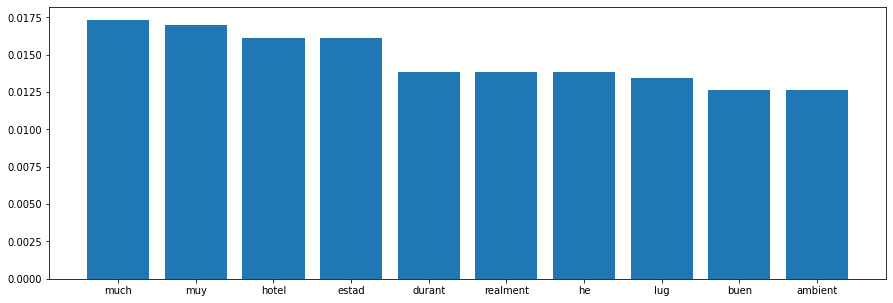

In [ ]:
# Tema utilizando modelo(tema) de fondo
palabras_mas_probables(Ptheta_d)

# PLSA sin modelo de fondo y removiendo stopwords (Unigram Model)

In [ ]:
comentarios_sin_stopwords = procesar_comentarios(comentarios) # procesamiento quitando stopwords
comentarios_sin_stopwords = [p for c in comentarios_sin_stopwords[:N] for p in c] # Hago un solo documento(comentario)
P = Counter(comentarios_sin_stopwords) # Cuento las frecuencias de cada palabra
for palabra in P:
  P[palabra] /= len(comentarios_sin_stopwords) # Divido entre el tamaño del documento

# P[w] = P(w | theta) = c(w, d) / | d |

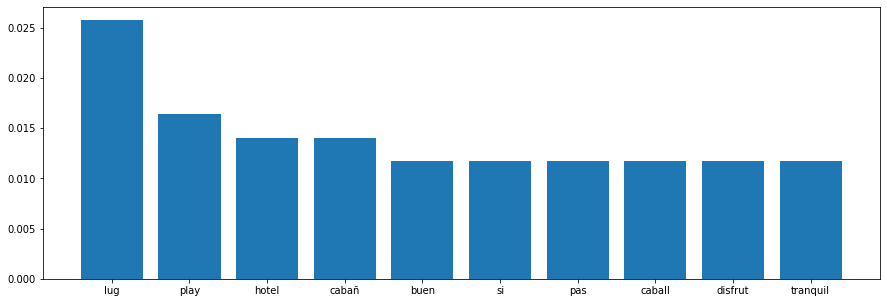

In [ ]:
# Tema sin modelo de fondo, quitando stopwords
palabras_mas_probables(P)

# Observaciones
1. Estimar el modelo de fondo usando los mismos datos hizo que el tema convergiera al mismo modelo de fondo
2. Estimar el modelo de fondo utilizando otros(más) datos hizo que el tema convergiera una distribución aceptable. Las palabras más probables eran signficativas
3. Estimar el tema sin modelo de fondo, solo quitando stopwords dio buenos resultados también.
4. Es probable que al tener más documentos y más temas, estimar el modelo de fondo con los mismos datos de buenos resultados.
5. Usar un tema de fondo es una buena opción si no se cuenta con una lista de stopwords.